# Data Validation Tutorial


<div markdown="1" style="background-color:rgba(200, 230, 250, 0.4); text-align:left; vertical-align: middle; padding:10px; width:900px;">
<p>

### Background: DESCQA / analysis_tools

[DESCQA](https://github.com/LSSTDESC/descqa) is a DESC project for running validation tests on simulated catalogs. These tests were developed primarily for the cosmoDC2 catalog and go all the way from looking at whether there are outliers in the data to reproducing cosmology plots. When doing early-stage validation for the real data we want to be a little more careful to avoid peeking at the cosmology ahead of time or replicating analysis pipelines, and instead focus on understanding the quality of the data. For this array of early data tests we have an SRV branch.

[analysis_tools](https://pipelines.lsst.io/v/daily/modules/lsst.analysis.tools/index.html) is the project's QA software. There's a lot of great functionality and pretty plots in there, it is installed anywhere with the lsst pipelines (There is a great description of the rho statistics test on the RSP [here](https://github.com/rubin-dp0/tutorial-notebooks/blob/main/DP02_12b_PSF_Science_Demo.ipynb) and I also have some notes on how to run analysis_tools at NERSC [here](https://lsstdesc.org/srv-dp02/tutorials/Rubin/tutorial3_Rubin_analysistools.html)) and there's a bunch of tests that you can see run by the operations team nightly here https://sitcomtn-124.lsst.io/. If you want to use or contribute to analysis_tools we are more than happy for tests to be developed in this format and run either by DESC or the project depending on the scope. 


</p></span>
<div>

## Set-up
This is much the same as the last tutorial except this time let's also add a descqa import



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/descqa')
import descqa

%matplotlib inline

## DESCQA - DESC-Quality Assurance Framework

https://arxiv.org/abs/1709.09665
https://arxiv.org/abs/2110.03769

Designed to allow us to validate and inspect the results of a range of catalogs, read in by the generic catalog reader. We're expanding this in the SRV branch to scale up in data size and run validation on the DP0.2 data.

<img src="./pictures/descqa.png"  width="1100">


This has traditionally been run on the terminal at NERSC, this can be as easy as cloning the repository and within the main folder typing 
```bash
./run_master.sh -c catalogs_to_run -t test_to_run
```
The test will then run, and output a url linking to the output of the test in the web browser. 

I'm going to show you how to run this in a jupyter notebook, as many people seem more comfortable developing interactively. To do this similarly the only two things we really need to know are which catalog to load and which test to run. Let's run one I made ahead of time for this called srv_tutorial on the catalog we currently have in hand, lsst_object. 

We're missing a bunch of exception catching here because I know these exist, if you want to see what those checks are we would typically run have a look [here](https://lsstdesc.org/srv-dp02/tutorials/Rubin/tutorial4_using_DESCQA.html)   


In [3]:
catalog = 'lsst_object'
validation = 'srv_tutorial'

catalog_instance =  GCRCatalogs.load_catalog(catalog)   
validation_instance = descqa.load_validation(validation)


We need to know where to output the result - for a proper terminal-based DESCQA run it would create an output directory in the DESC project space for you and show you where this is, but for developing I've created a sub-directory of this repo, and we can write the output to there. 

In [4]:

output_dir_this = './test_direc'  # point to a directory where you want to store any plots or results
test_result = validation_instance.run_on_single_catalog(catalog_instance, catalog, output_dir_this)


And let's use the interpretation script I've made earlier to inspect the returned test result (look in utils.py if you're curious)

In [5]:
from utils import interpret_result
interpret_result(test_result)


Status code:
VALIDATION_TEST_INSPECT

No pass/fail criterion specified, inspection only

Summary message:
made a histogram to inspect!


We can then look at any plots output into the directory (You can directly look through the file system or use a display within the notebook like I have here)

./test_direc/test_histogram.png


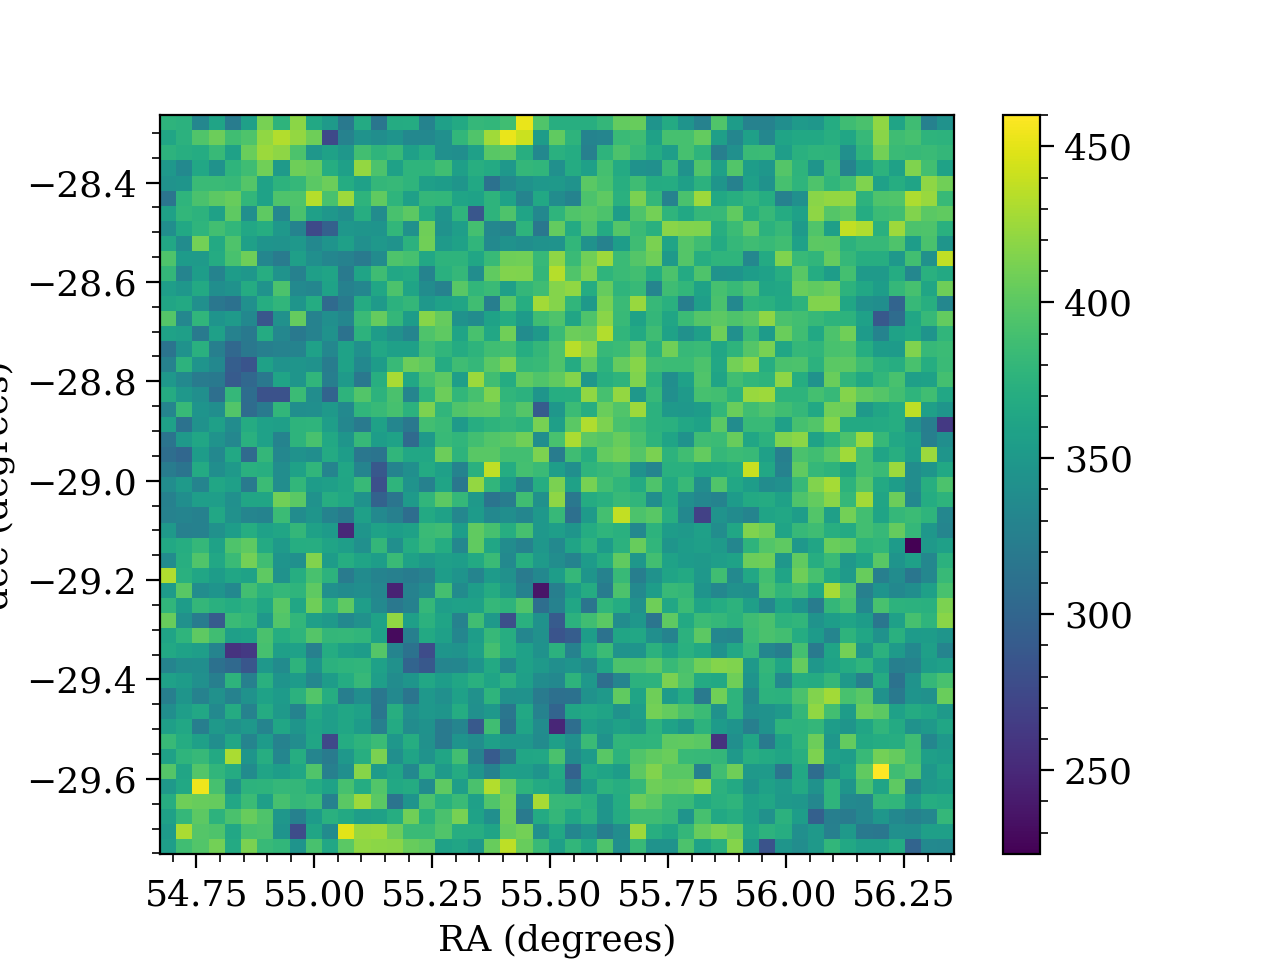

In [6]:
import glob
from PIL import Image
from IPython.display import display

for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))


<div markdown="1" style="background-color:rgba(200, 230, 250, 0.4); text-align:left; vertical-align: middle; padding:10px; width:900px;">
<p>

### Background: SRV tests

If you check out the SRV branch of DESCQA you'll see it's actually a little more complicated than that. In the run_master script you have options to do parallel reads, change the kernel to one with the lsst pipelines and set the environment. To run on the log-in node on Perlmutter you cannot import MPI or work with large datasets so for now we're developing things in a more simple environment. If you'd like to contribute a test and make it work in parallel, with GPUs or with lsst software, just let me know!

</p></span>
<div>

## How do we develop these tests?

You need roughly three things to develop a test 
* Input arguments 
* Some operation to perform on the data 
* An output to display the result

This is the exact code for what we just ran, except this time I thought we'd make it prettier by changing the color map and adding tight_layout to fix that pesky y-label issue. 

In [7]:
from descqa.base import BaseValidationTest, TestResult
import numpy as np
import healpy as hp
import os
import matplotlib.pyplot as plt
import matplotlib as mpl


class Tutorial2(BaseValidationTest):
    """
    validation test to plot RA/DEC
    """
    def __init__(self, **kwargs): # initialize and get the inputs 
        self.ra = kwargs.get('ra')
        self.dec = kwargs.get('dec')
        self.catalog_filters = kwargs.get('catalog_filters', [])


    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir): # run the operation

        if not catalog_instance.has_quantities([self.ra, self.dec]):
            return TestResult(skipped=True)

        # read in the data 
        data = catalog_instance.get_quantities([self.ra,self.dec],filters=self.catalog_filters, return_iterator=False)

        xbins = np.linspace(np.min(data[self.ra]),np.max(data[self.ra]),50)
        ybins = np.linspace(np.min(data[self.dec]),np.max(data[self.dec]),50)
        plt.figure()
        plt.hist2d(data[self.ra],data[self.dec], bins=(xbins,ybins),cmap='Blues')
        plt.colorbar()
        plt.xlabel('RA (degrees)')
        plt.ylabel('dec (degrees)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'test_histogram.png')) # create output #1 
        plt.close()

        return TestResult(inspect_only=True, summary='made a histogram to inspect!') # add output information


We need to create the inputs to pass in, we're just going to create a dictionary with the right key words, then all we need to do is initialize a validation with this class and the inputs and we're ready to run the test!

In [8]:
dict_config = {}
dict_config['ra'] = 'coord_ra'
dict_config['dec'] = 'coord_dec'
dict_config['catalog_filters'] =  ['refExtendedness==1','detect_isPrimary']

validation2 = Tutorial2(**dict_config)


./test_direc/test_histogram.png


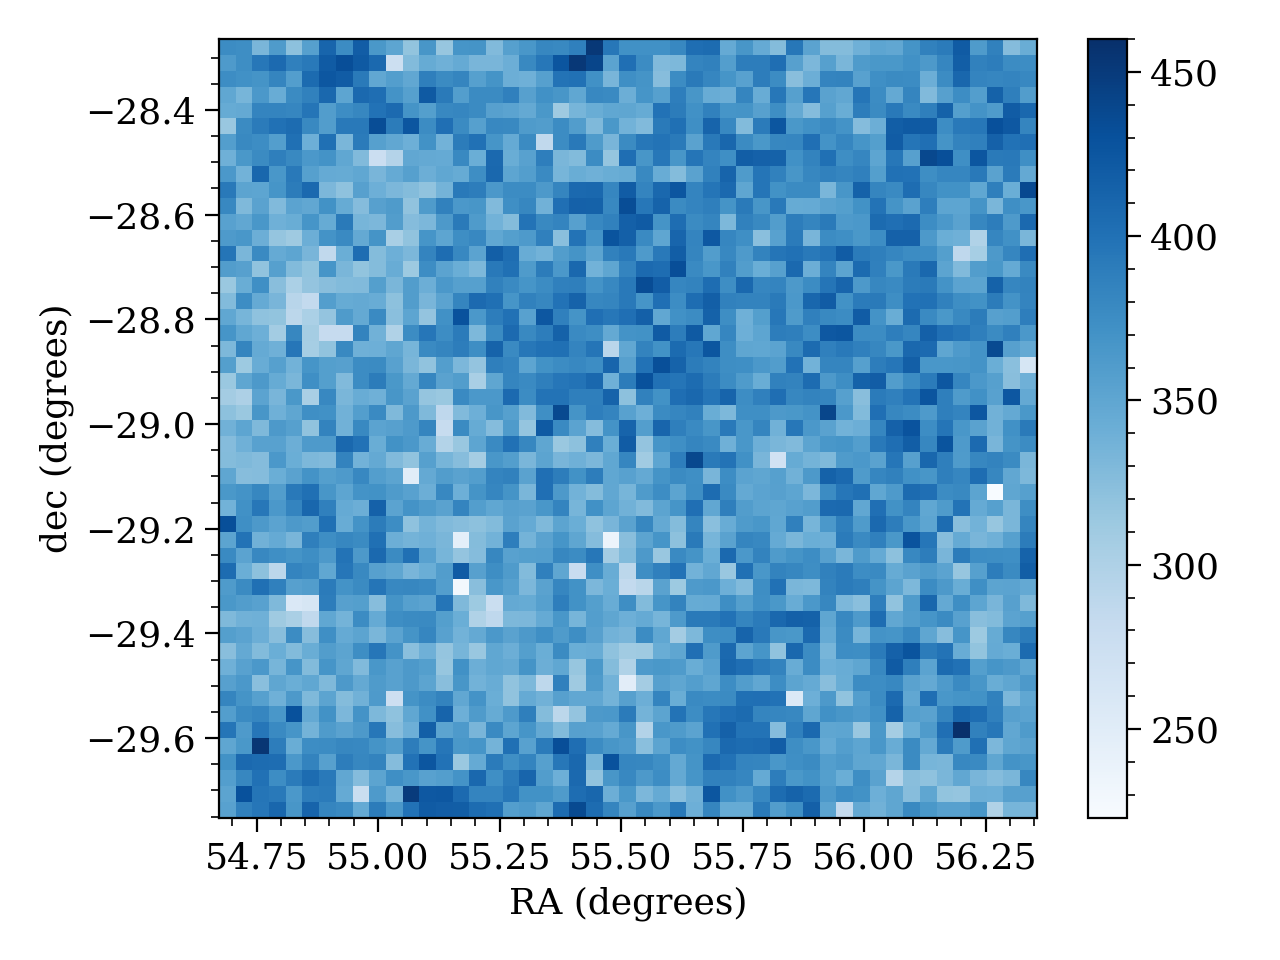

In [9]:
test_result = validation2.run_on_single_catalog(catalog_instance, catalog, output_dir_this)

for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))


### Slight extension..

Just for fun, let's change this histogram to plot the same PSF size variation plot we made in the answer section to the last notebook and put the band in as an input argument. 

We need to add the trace function, which we can do above the tutorial code, then we just need to compute it and plot the mean over those bins (I'm going to do that using binned_statistic_2d but you're welcome to use your favorite histogramming or plotting tools). 


In [10]:
from scipy.stats import binned_statistic_2d as bs2d
def trace(ixx,ixy,iyy):
    return (ixx+iyy)

    
class Tutorial3(BaseValidationTest):
    """
    validation test to plot RA/DEC
    """
    def __init__(self, **kwargs): #pylint: disable=W0231
        # get the inputs
        self.ra = kwargs.get('ra')
        self.dec = kwargs.get('dec')
        self.band = kwargs.get('band')
        self.catalog_filters = kwargs.get('catalog_filters', [])
        self.quantities =  kwargs.get('quantities', [])



    def run_on_single_catalog(self, catalog_instance, catalog_name, output_dir):


        if not catalog_instance.has_quantities([self.ra, self.dec]):
            return TestResult(skipped=True)
        filters=[]
        for i, filt in enumerate(self.catalog_filters):
            filters.append(filt)

            
        # read in the data 
        data = catalog_instance.get_quantities(self.quantities,filters=filters, return_iterator=False)
        
        data['T_PSF'] = trace(data[self.band+'_ixxPSF'],data[self.band+'_ixyPSF'],data[self.band+'_iyyPSF'])
        
        plt.title(self.band+'-band PSF size variation')
        val, xedge, yedge, bincount = bs2d(data["coord_ra"],data["coord_dec"],data['T_PSF'],statistic='mean',bins=100)
        plt.imshow(val,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]])
        plt.colorbar()
        plt.xlabel('RA (degrees)')
        plt.ylabel('dec (degrees)')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, 'test_histogram.png'))
        plt.close()


        return TestResult(inspect_only=True, summary='made a histogram to inspect!')


./test_direc/test_histogram.png


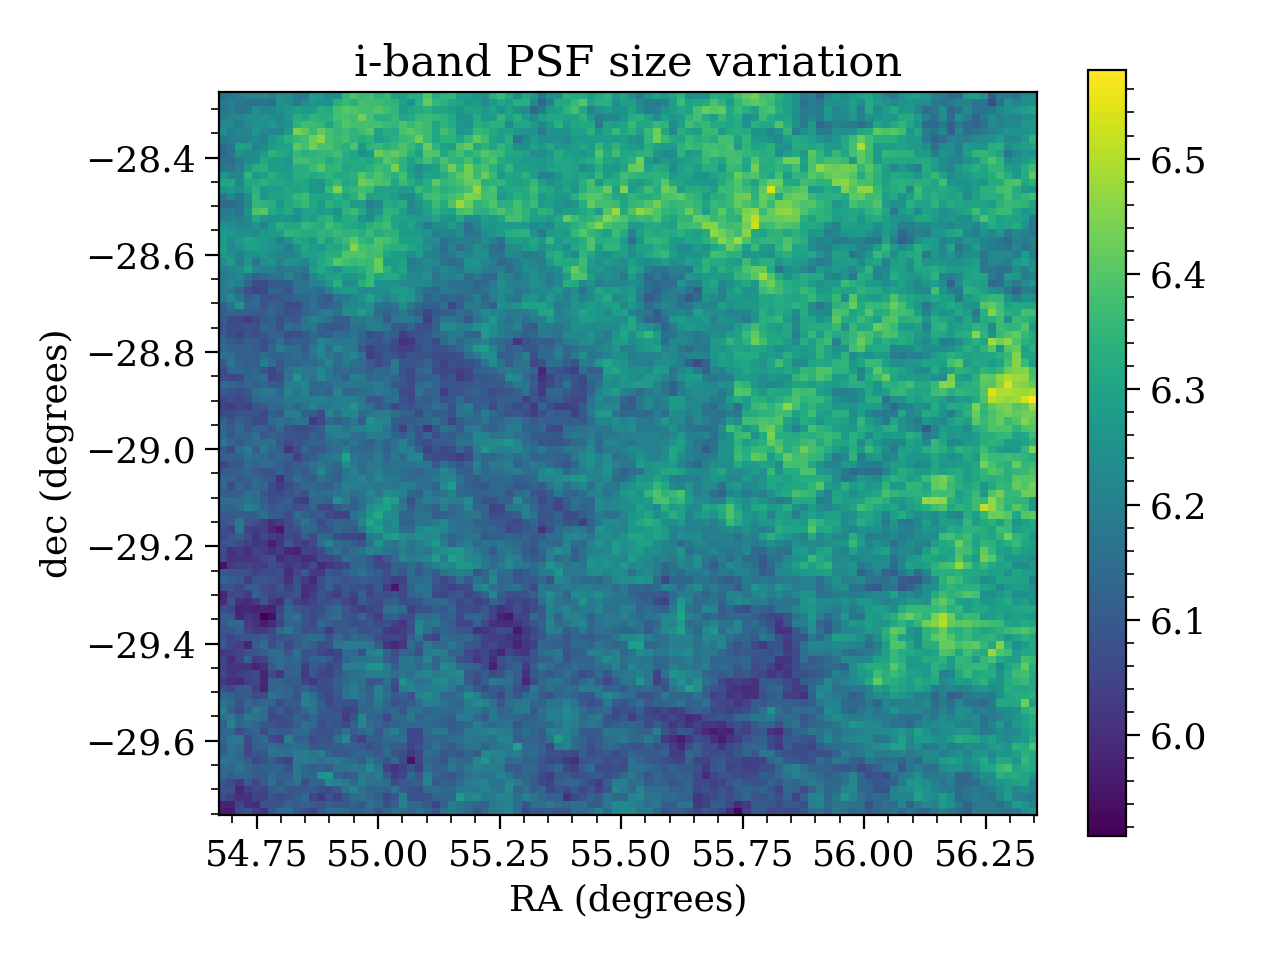

In [11]:
band = 'i'
dict_config = {}
dict_config['ra'] = 'coord_ra'
dict_config['dec'] = 'coord_dec'
dict_config['band'] = band
dict_config['quantities'] = ["coord_ra","coord_dec", band+"_ixxPSF", band+"_ixyPSF", band+"_iyyPSF",band+"_cModelFlux"]
dict_config['catalog_filters'] =  ['detect_isPrimary','refExtendedness==1']

validation3 = Tutorial3(**dict_config)
test_result = validation3.run_on_single_catalog(catalog_instance, catalog, output_dir_this)

for image in glob.glob( output_dir_this + '/*.png'):
    print(image)
    display(Image.open(image))
